# Ce projet fonctionne avec les versions des package suivants:

- matplotlib==3.9.0
- pandas==2.2.2
- seaborn==0.13.2
- missingno==0.5.2

## The Data
This is a dataset of food products listing the ingredients and nutritional facts of more than 300,000 foods from over 150 countries in the world. The data is meant to be free to the public to help users decode food labels, and make better food choices in general. The dataset contains more than 300,000 rows over 163 columns. However, as we will see there are a lot of missing or obviously incorrect values.<br/>
Generalities:

- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product


# Importation des packages

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import tkinter as tk
from tkinter import filedialog

import missingno as msno
from wordcloud import WordCloud
from IPython.display import display, HTML

# Nettoyer et Filtrer les Features et Produits

## 1.1. Collecter et Préparer les Données Brutes
### 1. Charger les données dans un DataFrame Pandas

In [7]:
print('Initialisation du projet...', end='\r')
filepath ='datas/openfoodfacts.csv'
target ='main_category_fr'
selected = ['countries_fr','energy_100g','salt_100g','nutrition_grade_fr']
data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
print(' '*len('Initialisation du projet...'), end='\r')
print('Projet chargé')

Projet chargé              


In [8]:
def select_file():
    print("charger le nouveau fichier")
    root =tk.Tk()
    root.withdraw()

    filepath = filedialog.askopenfilename(
        title="Choisissez votre fichier csv",
        filetypes=(("Fichiers CSV","*.csv"), ("Tous les fichiers","*.*"))
    )
    print(' '*len("charger le nouveau fichier"),end='\r')
    print("chargement en cours...")
    root.destroy()

    if filepath:
        try:
            data = pd.read_csv(f"{filepath}", sep="\t", encoding="utf-8", on_bad_lines="skip", low_memory=False)
            print(' '*len("chargement en cours..."),end='\r')
            print(f"Fichier chargé avec succès depuis le chemin: {filepath}")
            return data
        except Exeption as e:
            print("Erreur lors du chargement du fichier:",e)
    else:
        print("Aucun fichier sélectionné.")

In [9]:
data.head()

code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                    14.0                    14.0   
2                   NaN                     0.0                     0.0   
3                   NaN                    12.0                    12.0   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 162 columns]

In [10]:
# changement d'index
data = data.set_index('code')

In [11]:
# Analyse de la dimension de la base de données
data.shape

(320772, 161)

In [12]:
#Analyse de l'ensemble des variables de la base de données
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 320772 entries, 0000000003087 to 999990026839
Data columns (total 161 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    url                                         320749 non-null  object 
 1    creator                                     320770 non-null  object 
 2    created_t                                   320769 non-null  object 
 3    created_datetime                            320763 non-null  object 
 4    last_modified_t                             320772 non-null  object 
 5    last_modified_datetime                      320772 non-null  object 
 6    product_name                                303010 non-null  object 
 7    generic_name                                52795 non-null   object 
 8    quantity                                    104819 non-null  object 
 9    packaging                                   

In [13]:
data.isna().sum()

url                            23
creator                         2
created_t                       3
created_datetime                9
last_modified_t                 0
                            ...  
carbon-footprint_100g      320504
nutrition-score-fr_100g     99562
nutrition-score-uk_100g     99562
glycemic-index_100g        320772
water-hardness_100g        320772
Length: 161, dtype: int64

In [14]:
url='https://world.openfoodfacts.org/data/data-fields.txt'
df_description = pd.read_csv(url, sep="\t", encoding="utf-8", comment='#', header=None)
fields={}
current_category=None
for index, row in df_description.iterrows():
    line =row[0]
    if line.startswith ('#'):
        continue
    if ':' in line:
        key, description=line.split(':',1)
        fields[key.strip()]=description.strip()
    elif len(line.strip()) == 0:
        continue
    else:
        current_category=line.strip()

for key in list(fields.keys()):
    print(f"{key}: {fields[key]}")

See https: //world.openfoodfacts.org/data for more information.
Generalities: 
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
List of fields: 
code: barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix
url: url of the product page on Open Food Facts
creator: contributor who first added the product
created_t: date that the product was added (UNIX timestamp format)
created_datetime: date that the product was added (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
last_modified_t: date that the product page was last modified
product_name: name of the product
quantity: quantity and unit
packaging: shape, material
origins: origins of ingredients
manufacturing_places: places where manufactured or transformed
first_packaging_code_geo: coordinates corresponding to the first packaging code indicated
countries: list of countries where the p

In [15]:
# Analyse du type de variables dans la base de données
pd.set_option('display.max_rows',None)
print(data.dtypes)

url                                            object
creator                                        object
created_t                                      object
created_datetime                               object
last_modified_t                                object
last_modified_datetime                         object
product_name                                   object
generic_name                                   object
quantity                                       object
packaging                                      object
packaging_tags                                 object
brands                                         object
brands_tags                                    object
categories                                     object
categories_tags                                object
categories_fr                                  object
origins                                        object
origins_tags                                   object
manufacturing_places        

## 1.2. Identifier et Sélectionner les Features Pertinentes
### 1.Lister les Features (Colonnes) :

In [17]:
def feature_list(data):
    features = data.columns
    return features

### 2.Séparer les Features Quantitatives et Qualitatives :

In [19]:
def split_features(data):
    quantitative_features = data.select_dtypes(include=['float64','int64'])
    qualitative_features = data.select_dtypes(include=['object'])
    return quantitative_features,qualitative_features

## 1.3. Choisir une Cible

### 1.Choisir une Feature Cible avec Moins de 50% de Valeurs Présentes :

In [22]:
def target_choice(qualitative_features):
    # Calcule le pourcentage de valeurs manquantes pour chaque colonne
    missing_percentages = data.isnull().mean() *100
    
    #Filtrer les features ayant moins de 50% de valeurs manquantes.
    features_with_less_than_50_missing = missing_percentages[missing_percentages > 50]
    
    # Trier par ordre décroissant de pourcentage de valeurs manquantes
    sorted_features = features_with_less_than_50_missing.sort_values(ascending=False)
    
    potential_targets = [feature for feature in sorted_features.index if feature in qualitative_features]

    print(f'{len(potential_targets)} cibles potentiels avec moins de 50% des valeurs / {len(qualitative_features.columns)} features dans l\'ordre. \nSelectionner votre cible dans la liste suivantes :')
    for index, feature in enumerate(potential_targets):
        nb_fill_each_value= data[feature].count()
        val_null= data[feature].isna().sum()
        percentage_fill_each_value = (nb_fill_each_value / len(qualitative_features) * 100).round(2)
        print(f"{index+1}: {feature}: {percentage_fill_each_value}% des valeurs présentes soit {nb_fill_each_value} valeurs")
    try:
        selected_index = int(input('Entrer l\'index de votre cible:'))
        target = potential_targets[selected_index-1]
        print("Feature cible selectionnée:", target)
    except IndexError:
        print("Invalid index. Please restart the selection process.")
    except ValueError:
        print("Invalid input. Please enter a numeric index.")
    return target

### Supprimer les Lignes (Produits) Sans Valeur Cible :


In [24]:
def clean_row_without_target(data,target):
    print('suppression des lignes sans cible...',end='\r')
    data_nan = data[data[target].isna()]
    data_cleaned = data.dropna(subset=[target])
    result = data_cleaned.shape
    print(' '*len('suppression des lignes sans cible...'), end='\r')
    print('✅ Lignes sans cible supprimées')
    return data_cleaned
#data_nan.shape

### 3.Séparer la Cible du Reste du Dataset :


In [26]:
def split_dataset_from_target(data_cleaned,target):
    print('Séparation de la cible du reste du dataset...',end='\r')
    df_without_target = data_cleaned.drop(columns=[target])
    df_with_target=data_cleaned[target]
    print(' '*len('Séparation de la cible du reste du dataset...'),end='\r')
    print('✅ Cible séparée du reste du dataset')
    return df_without_target

## 1.4. Afficher les Taux de Remplissage des Features

In [28]:
def filling_rate_display(data_cleaned,df_without_target):
    display(HTML("<h2 style='color: navy'>Taux de remplissage</h2>"))
    print('Affichage en cours...',end='\r')
    filling_rates = data_cleaned.notnull().mean()*100
    sorted_value=df_without_target.count().sort_values(ascending=True)
    sorted_df =df_without_target[sorted_value.index]
    msno.bar(sorted_df)
    msno.matrix(sorted_df)
    msno.heatmap(sorted_df)
    print(' '*len('Affichage en cours...'),end='\r')

## 1.5. Sélectionner des Features Intéressantes

### Sélectionner les Features avec Plus de 50% de Valeurs Présentes :

In [31]:
def select_features_with_more_than_50(df_without_target):
    # Calcul le pourcentage de valeurs non nulles pour les colonnes quantitatives
    df_without_target=df_without_target.notnull().mean()*100

    # Sélectionne les features avec plus de 50% de valeurs non nulles
    selected_features = df_without_target[df_without_target>50].index

    # Créer un DataFrame pour afficher les résultats
    selected_features = pd.DataFrame(selected_features,columns=['Features'])
    print('Feature ayant plus de 50% de valeurs que vous pouvez selectionner:\n ')
    for index ,row in selected_features.iterrows():
        print(f'{index+1} : {row["Features"]}')
    return selected_features

In [32]:
def features_selection(selected,selected_features):
    nb_element = int(input('Combien de feature voulez-vous utiliser (recommandé 3)'))
    print(f'Selectionnez 1 à {nb_element} éléments:\n')
    old_selected = selected
    selected = [] # Pour stocker les features choisis
    while len(selected) < nb_element:
        if len(selected)<nb_element:
            choice_index= input(f"Entrez le numéro de votre choix numéro {len(selected)+1} ou tapez fin pour garder le choix initial")
            if choice_index.lower()=='fin':
                if len(selected)==0:
                    selected = old_selected
                else:
                    return selected
            else:
                try:
                    choice_index= int(choice_index)-1
                    if 0<= choice_index <len(selected_features):
                        feature = selected_features.iloc[choice_index]['Features']
                        if feature not in selected:
                            selected.append(feature)
                            print(f'Vous avez selectionné {feature}')
                            print(f'Features selectionnées:{selected}')
                        else:
                            print("Vous avez déjà sélectionné cette feature. Veuillez choisir une autre.")
                    else:
                        print('Numéro de choix invalide, veuillez entrer un numéro valide.')
                except ValueError:
                    print("Entrée invalide, veuillez entrer un numéro entier.")
    return selected

In [33]:
def clean_duplicate(data_cleaned, target, selected):
    num_rows, num_cols = data_cleaned.shape

    display(HTML("<h2 style='color: navy'>Nettoyage des doublon</h2>"))

    print(f'Nombre de lignes avant nettoyage : {num_rows}')

    columns_to_check = [target] + selected  # Ajoute 'target' à la liste 'selected'
    print(f'Est considéré comme doublons toutes les lignes ayant des valeurs identique sur l\'ensembles des colonnes {columns_to_check}')
    
    data_after_cleaned = data_cleaned.drop_duplicates(subset =columns_to_check)
    data_after_cleaned = data_after_cleaned.reset_index(drop=True)
    num_rows_after, num_cols_after = data_after_cleaned.shape

    print(f'Nombre de lignes après nettoyage : {num_rows_after}')
    return data_after_cleaned

# Automatisation Partie 1: Nettoyer et filtrer les features et produits

Paramètre par défaut:

chemin du fichier:
 --> datas/openfoodfacts.csv

Cible de l'analyse:
 --> main_category_fr

Features de l'analyse:
 --> ['countries_fr', 'energy_100g', 'salt_100g', 'nutrition_grade_fr']



Souhaitez-vous changer les paramètres par défault?
 O (Oui) / N (Non) n


✅ Lignes sans cible supprimées      
✅ Cible séparée du reste du dataset          


Nombre de lignes avant nettoyage : 84366
Est considéré comme doublons toutes les lignes ayant des valeurs identique sur l'ensembles des colonnes ['main_category_fr', 'countries_fr', 'energy_100g', 'salt_100g', 'nutrition_grade_fr']
Nombre de lignes après nettoyage : 58695


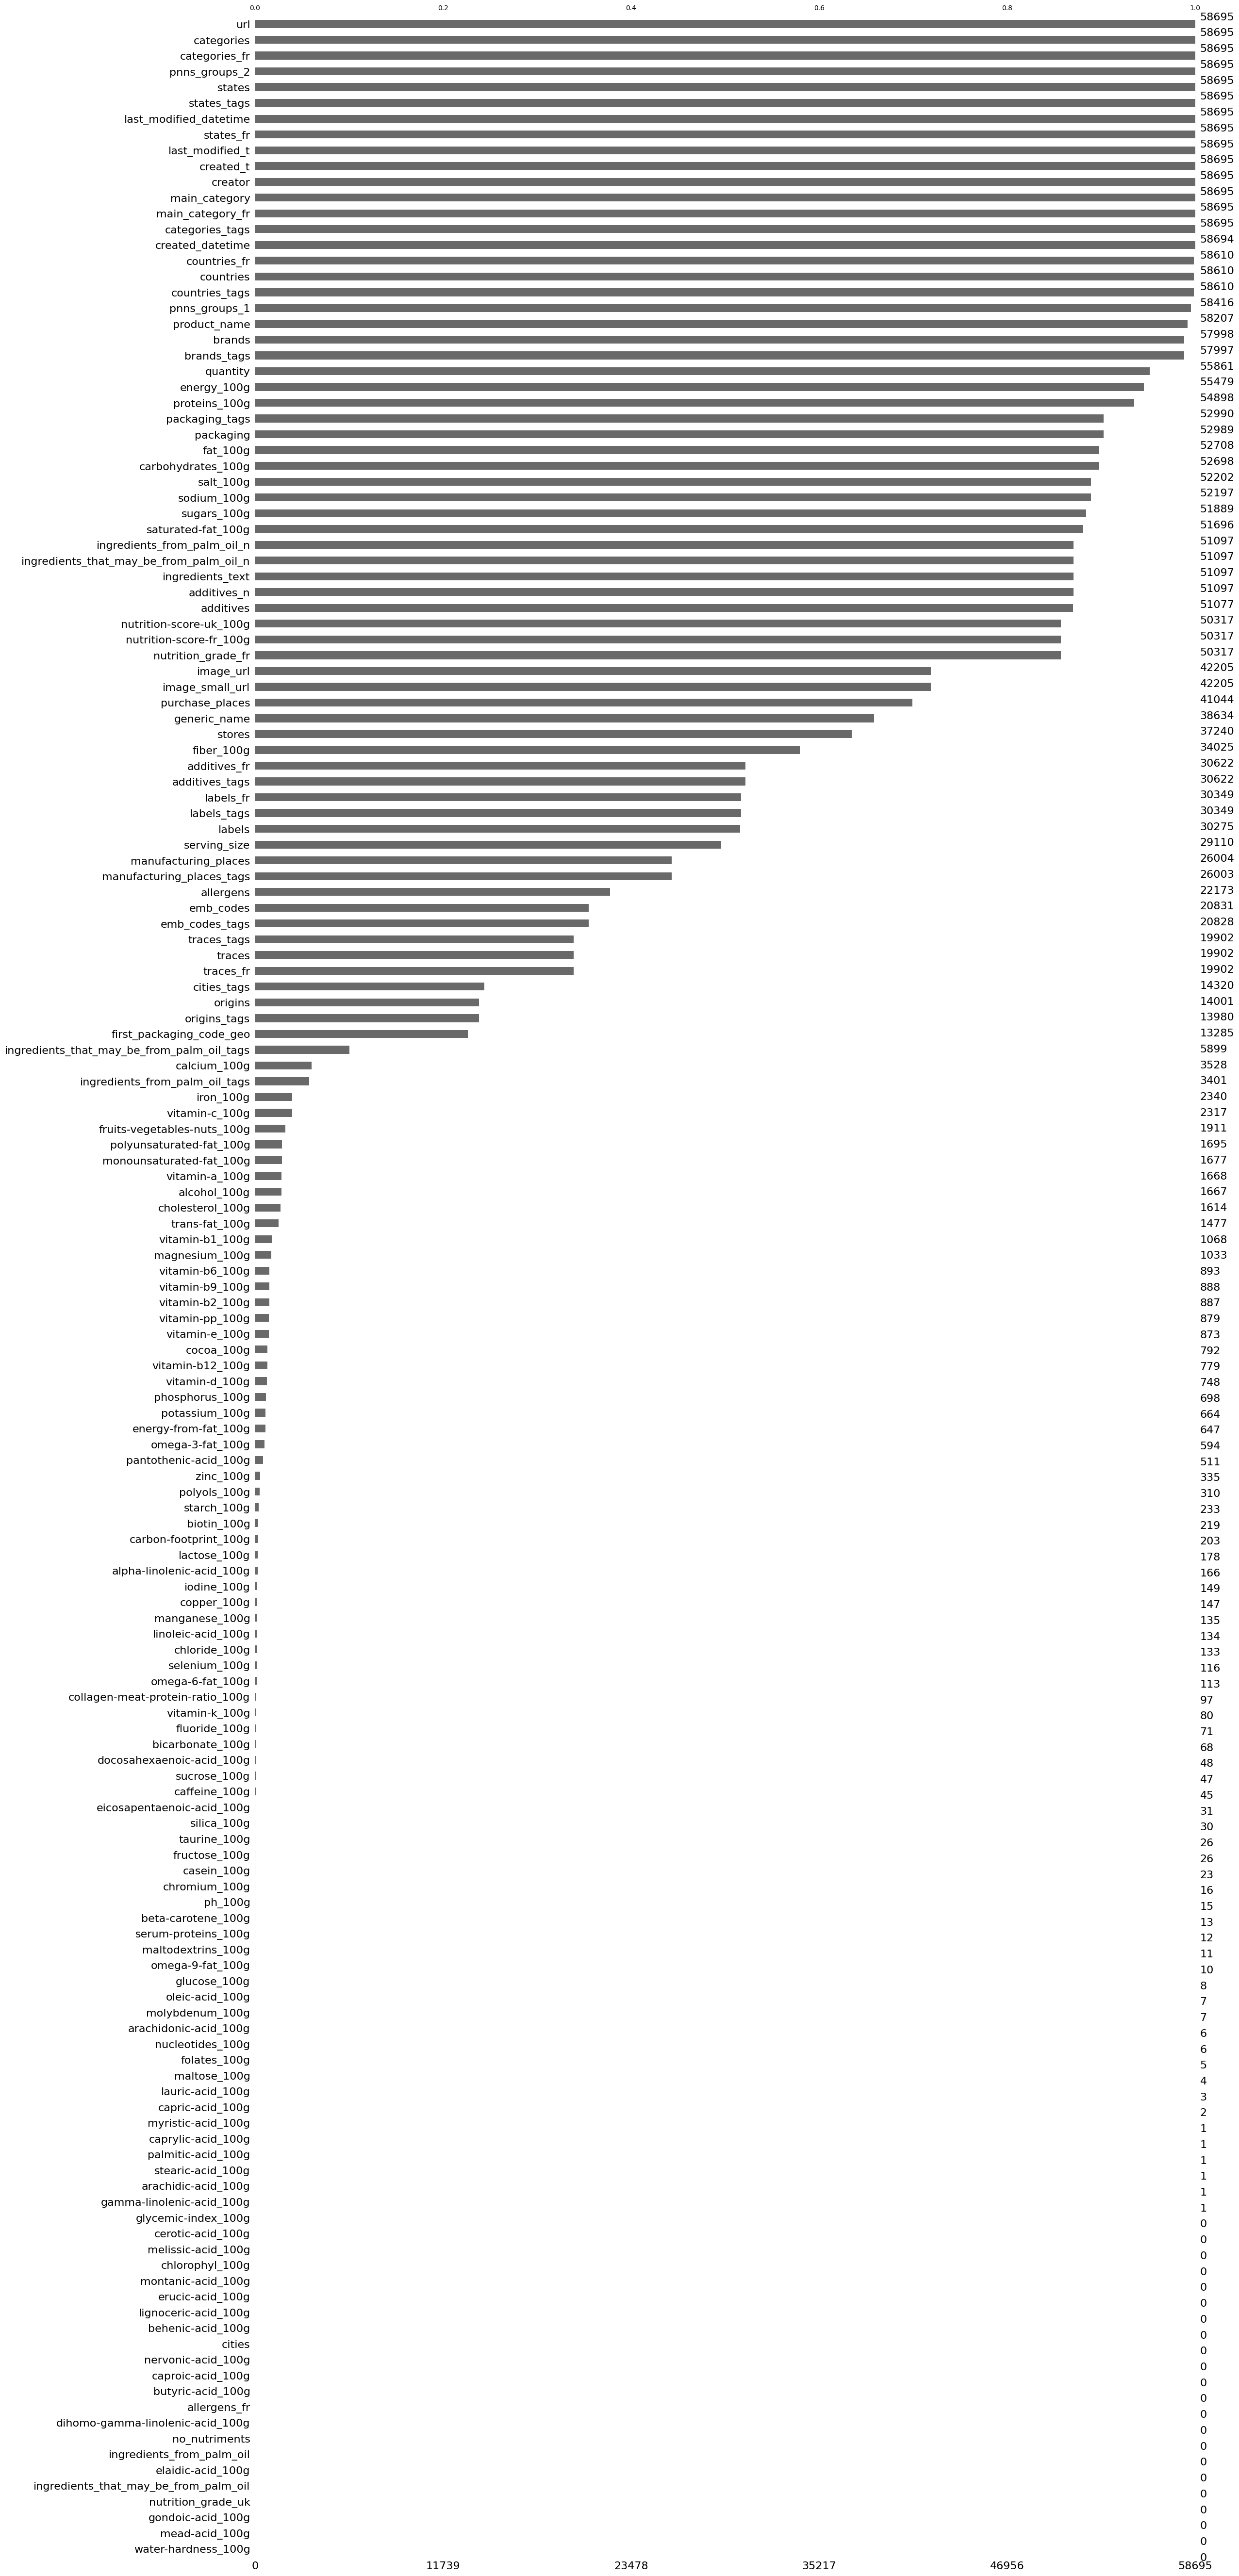

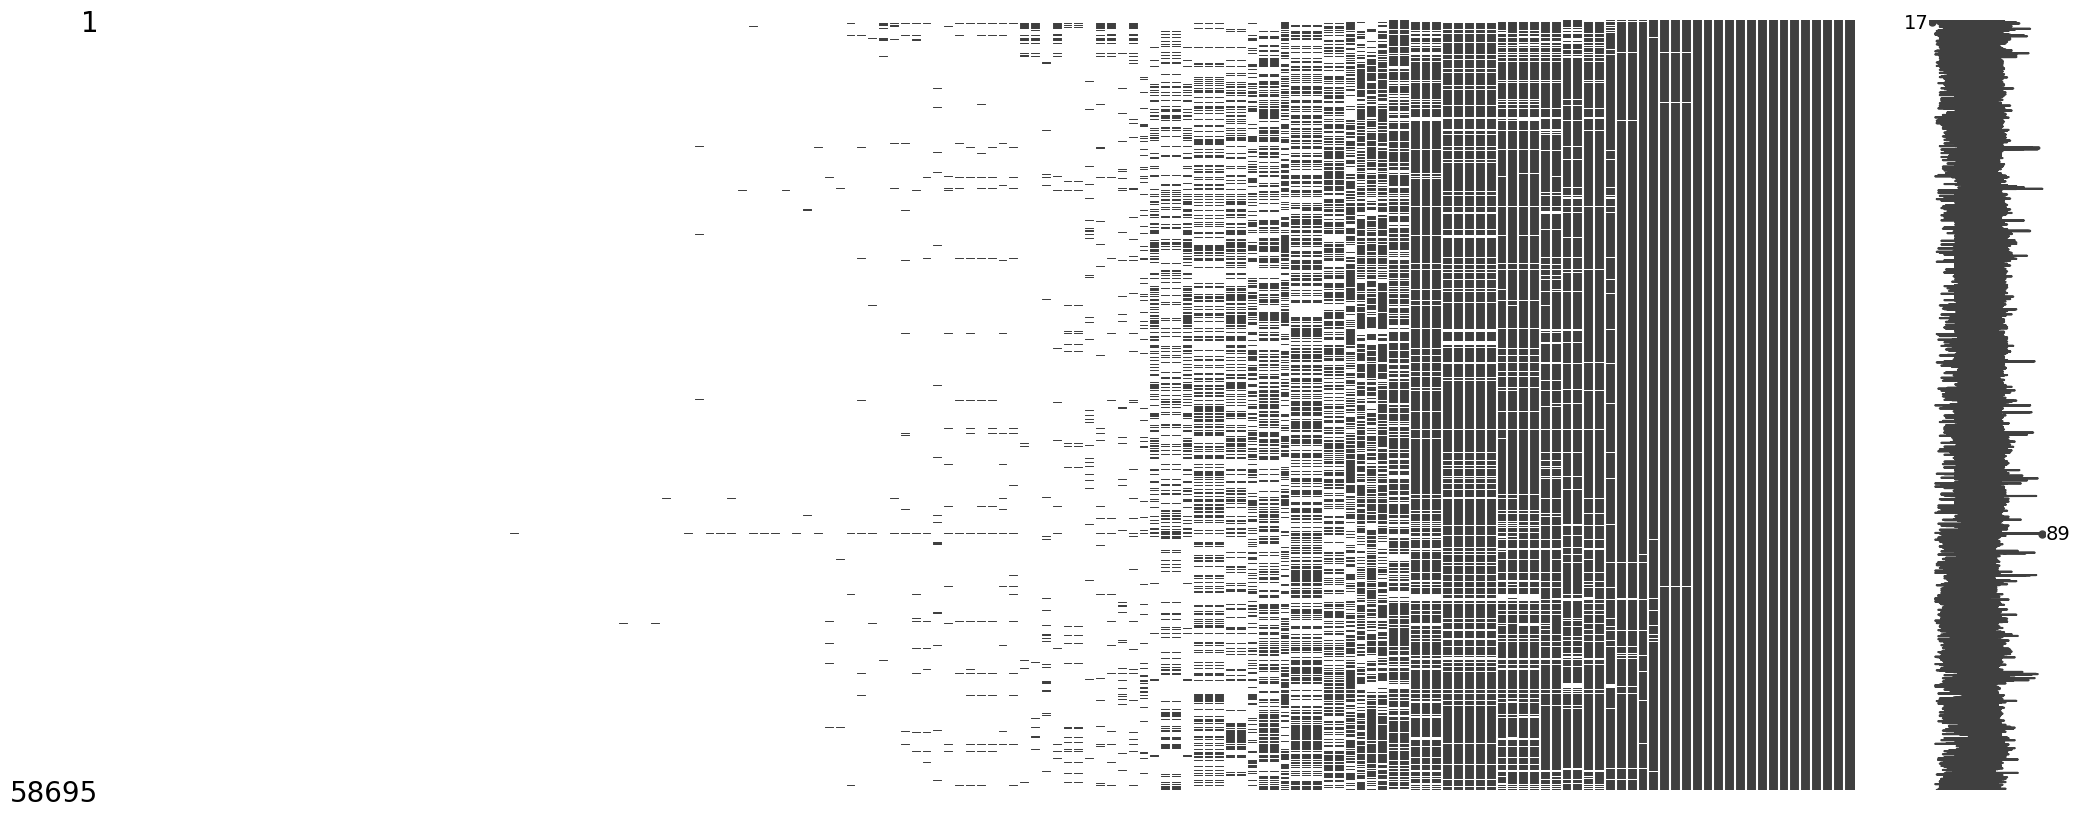

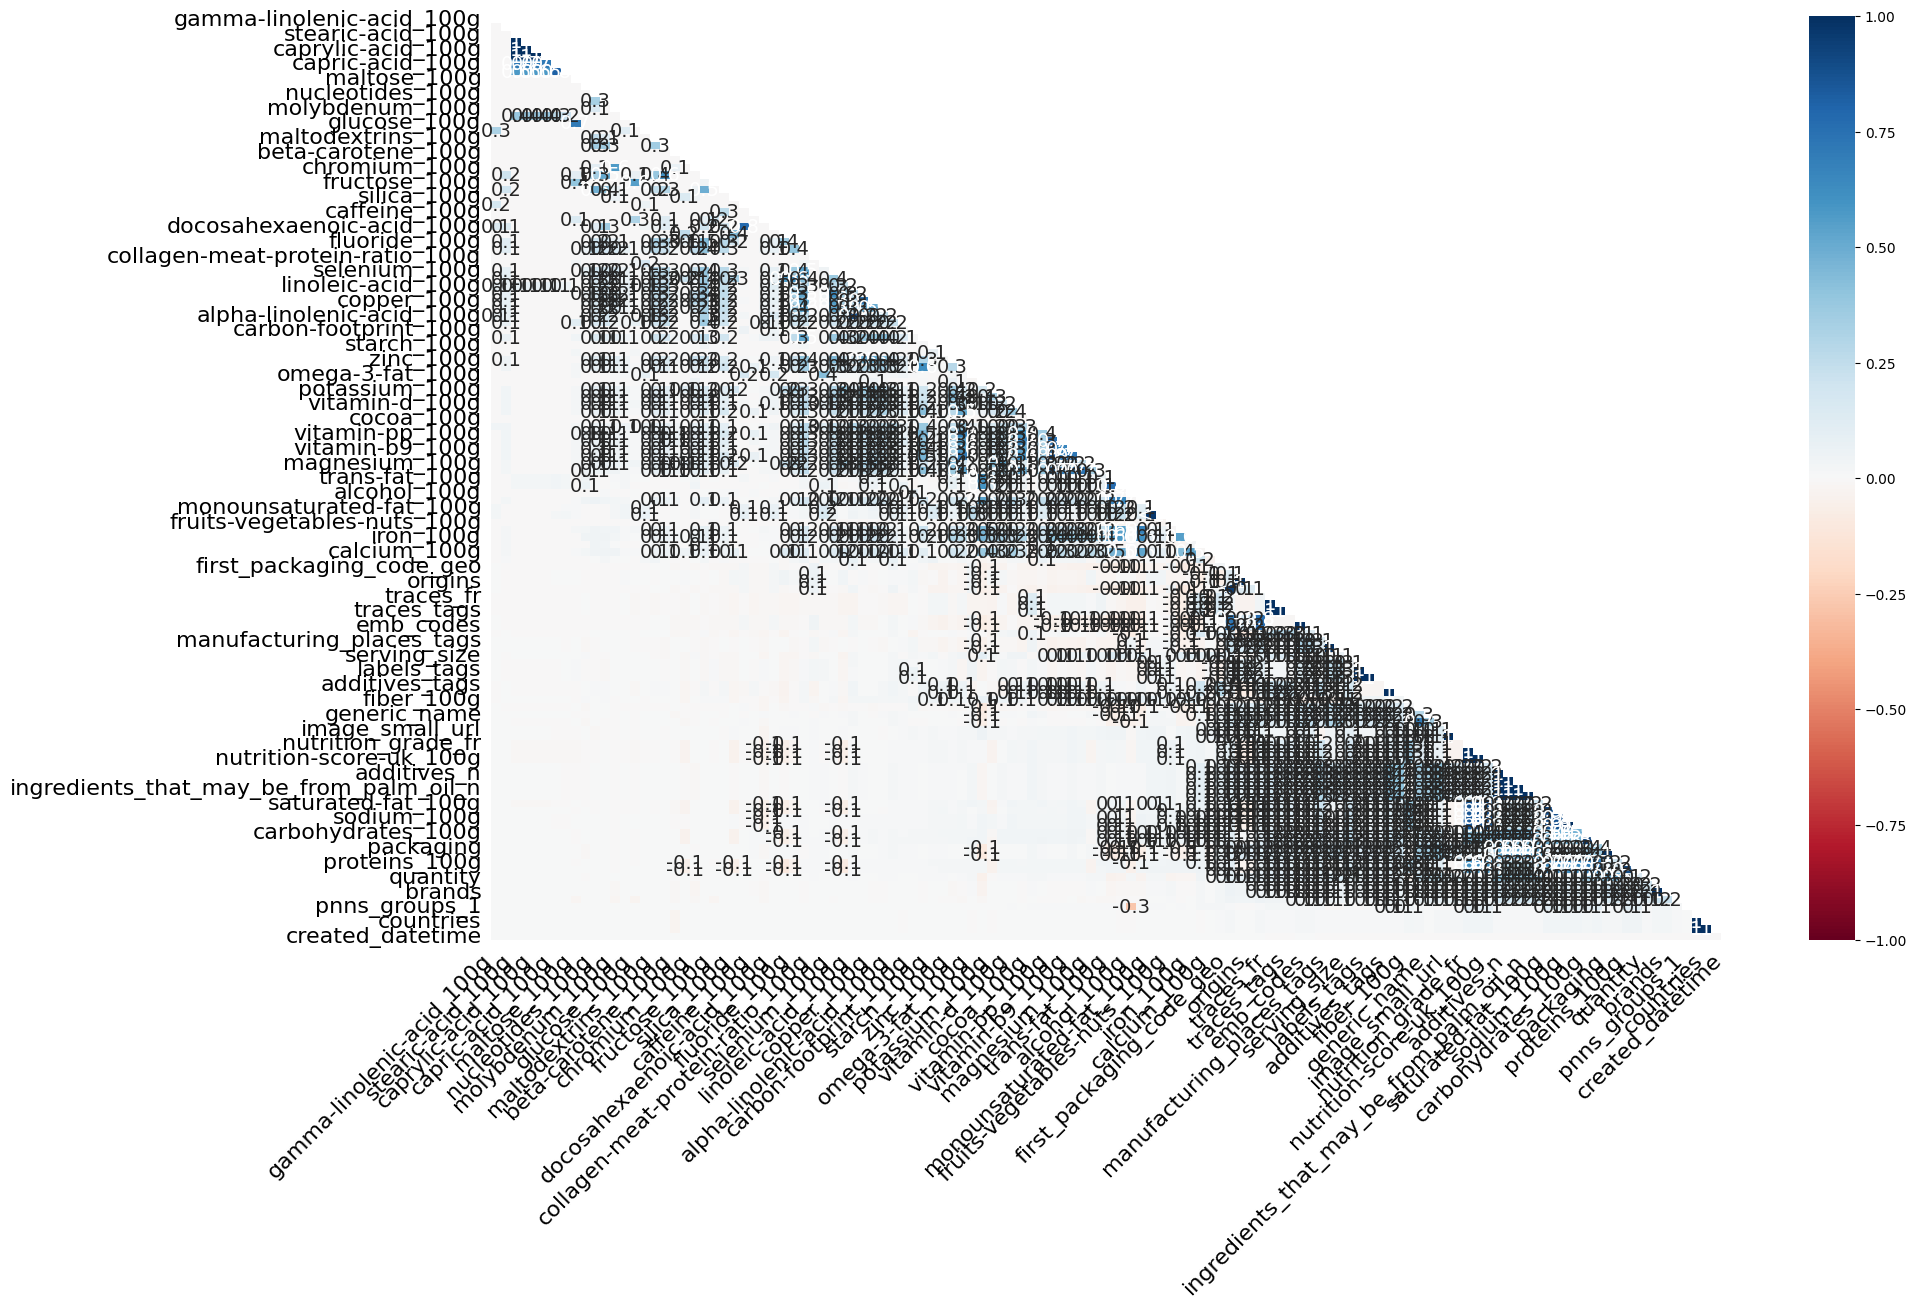

In [35]:
#filepath,target,selected, data=init() #initialisation du fichier local avec la première selection de paramètres
print('Paramètre par défaut:\n')
print(f'chemin du fichier:\n --> {filepath}\n')
print(f'Cible de l\'analyse:\n --> {target}\n')
print(f'Features de l\'analyse:\n --> {selected}\n')


default_params=input('Souhaitez-vous changer les paramètres par défault?\n O (Oui) / N (Non)')

if default_params.lower() == "o":
    
    filepath_params=input('Souhaitez-vous changer de fichier?\n O (Oui) / N (Non)')
    
    if filepath_params.lower()=='o': # Change le fichier de jeu de données
        data = select_file()  #Fonction de selection du nouveau fichier
        feature_list(data) # Liste des colonnes avec le nouveau ficher
    
    quantitative_features, qualitative_features = split_features(data) #Features avec le nouveau ficher
    
    target_params=input(f'Souhaitez-vous changer la cible d\'analye? {target}\n O (Oui) / N (Non)')
    if target_params.lower()=='o':
        target = target_choice(qualitative_features) # Change la cible d'analyse
        data_cleaned = clean_row_without_target(data,target) # Supprime les ligne n'ayant pas de cible
        df_without_target = split_dataset_from_target(data_cleaned,target) #sépare et recupère un dataframe sans la colonne cible    
    print(f"cible d'analyse: {target}")

    selected_params=input(f'Souhaitez-vous changer de Features? actuellement {selected}\n O (Oui) / N (Non)')
    if selected_params.lower()=='o':
        if filepath_params.lower()!='o':
            data_cleaned = clean_row_without_target(data,target) # Supprime les ligne n'ayant pas de cible
            df_without_target = split_dataset_from_target(data_cleaned,target) #sépare et recupère un dataframe sans la colonne cible
    selected_features=select_features_with_more_than_50(df_without_target)      
    selected =features_selection(selected,selected_features)
    print(f'Nouvelles Features selectionnées:{selected}')    
else:
    quantitative_features, qualitative_features = split_features(data)
    data_cleaned = clean_row_without_target(data,target)
    df_without_target = split_dataset_from_target(data_cleaned,target)

data_clean_duplicate=clean_duplicate(data_cleaned,target, selected)
filling_rate_display(data_cleaned,data_clean_duplicate)

columns_to_keep = ['product_name','url'] + [target] + selected

data_filtered = data_clean_duplicate[columns_to_keep]

# Identifier et traitez les valeurs aberrantes

In [37]:
def missing_value_prop(data_filtered):
    display(HTML("<h2 style='color: navy;'>Proportion des valeurs manquantes de la cible et des features selectionnées</h2>"))
    data_filtered_copy=data_filtered.isnull().mean()
    
    data_filtered_copy=data_filtered_copy.sort_values(ascending=False)
    
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.barplot(x=data_filtered_copy.index, y=data_filtered_copy.values, ax=ax,color='blue')
    
    ax.set_xlabel('Features')
    ax.set_ylabel('Proportion des valeurs manquantes')
    ax.tick_params(axis='x', rotation=90)
    # ax.set_xticklabels(data_filtered_copy.index, rotation=90)
    ax.set_title('Proportion des valeurs manquantes par features')
    plt.show()

In [38]:
font_paths = [
    '/Users/yann/FromNas/Training/IA Engineer/P3_santePublique/dejavu-fonts-ttf-2.37/ttf/DejaVuSans.ttf',  # DejaVu Sans
    '/Users/yann/Library/Fonts/NotoSansCJK.ttc',  # Noto Sans CJK pour les caractères chinois, japonais et coréens
    '/Users/yann/Library/Fonts/NotoSansThai-VariableFont_wdth,wght.ttf'
]
font_props = [fm.FontProperties(fname=font_path) for font_path in font_paths]
plt.rcParams['font.family'] = [fp.get_name() for fp in font_props]
def clean_text(text):
    return ''.join([char if ord(char)>=32 else '' for char in text])

In [39]:
def graph_analysis(data_filtered):

    html_content = """
    <h2 style='color: navy;'>Graphe de distribution de la cible et des features selectionnées</h2>
    <p>Un scatterplot si la feature est quantitative et un countplot si qualitative</p>
    """
    display(HTML(html_content))
    quantitative_features, qualitative_features = split_features(data_filtered)
    threshold = 10
    threshold_target = 20
    
    value_counts_target = data_filtered[target].value_counts()
    to_keep_target = value_counts_target[value_counts_target>threshold_target].index
    data_filtered_backup = data_filtered.copy()
    data_filtered[f'{target}_simplified'] = data_filtered[target].apply(lambda x: x if x in to_keep_target else 'Autres')
    
    plt.figure(figsize=(20, 6))
    
    if data_filtered[target].nunique()<20:
        fig, ax =plt.subplots(figsize=(16,14))
        counts = data_filtered[target].value_counts()  # Comptez les occurrences de chaque catégorie
        ax.pie(counts, labels=None, autopct='%1.1f%%',  textprops={'size': 'smaller'},pctdistance=1.1)
        ax.legend(wedges, counts.index, title=target, loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))
        ax.axis('equal')
        plt.title(f'Distribution of {target}')
        plt.show()
        
    else:
        sns.countplot(x=f'{target}_simplified', data=data_filtered)
        plt.title(f'Distribution of {target}')
        plt.xticks(rotation=90, fontsize=6)
        plt.show()
        
    check_feat_nbr = 0
    for feat in selected:
        check_feat_nbr +=1 
        if feat in qualitative_features.columns:
            value_counts = data_filtered[feat].value_counts()
            to_keep = value_counts[value_counts>threshold].index
            data_filtered.loc[:,f'{feat}_simplified']=data_filtered[feat].apply(lambda x:x if x in to_keep else 'Autres')
            # print(f'{feat} is in')
            plt.figure(figsize=(20, 6))
            sns.countplot(x=f'{feat}_simplified', data=data_filtered)
            plt.title(f'Distribution of {feat}')
            plt.xticks(rotation=90, fontsize=8)
            plt.show()
            # plt.tight_layout()
        else:
            plt.figure(figsize=(20, 6))
            sns.scatterplot( y=feat, x=f'{target}_simplified', data=data_filtered)
            plt.title(f'Distribution of {target}_simplified vs {feat}')
            plt.xticks(rotation=90, fontsize=6)
            plt.show()     
            
        if check_feat_nbr == len(selected):
            data_filtered=data_filtered_backup

In [40]:
def boxplot_before_IQR(quantitative_features,data_filtered):
    display(HTML("<h2 style='color: navy;'>Boxplot AVANT traitement des valeurs abérrantes</h2>"))
    for feature in data_filtered:
        if feature in quantitative_features.columns:
            sns.boxplot(y=feature, data=data_filtered)
            plt.title(f'Boxplot of {feature} with outliers')
            plt.show()

In [41]:
def box_outliers(quantitative_features,feature):
    Q1 = quantitative_features[feature].quantile(0.25)
    Q3 = quantitative_features[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = max(0,Q1 - 1.5 * IQR)
    upper_limit = Q3 + 1.5 * IQR
    outliers = (quantitative_features[feature]<lower_limit) | (quantitative_features[feature]>upper_limit)
    return outliers, lower_limit, upper_limit

In [42]:
def outliers_calc(quantitative_features,data_filtered):
    display(HTML("<h2 style='color: navy;'>Boxplot APRÈS traitement des valeurs abérrantes avec IQR</h2>"))

    for feature in data_filtered:
        if feature in quantitative_features.columns:
            outliers, lower_limit, upper_limit = box_outliers(quantitative_features,feature)
            print(f'Outliers de {feature}')
            print(f'lower_limit de {feature}: {lower_limit}')
            print(f'upper_limit de {feature}: {upper_limit}')
            quant_data_df_outliers = quantitative_features[(quantitative_features[feature]>=lower_limit) & (quantitative_features[feature]<=upper_limit)]
            sns.boxplot(y=feature, data=quant_data_df_outliers)
            plt.title(f'Boxplot of {feature} without outliers')
            plt.show()

In [43]:
def worcloud_graph(data_filtered,qualitative_features):
    columns_to_exclude = ['code','nutrition_grade_fr', 'url']  # Ajoutez d'autres colonnes ici si nécessaire
    display(HTML("<h2 style='color: navy;'>Nuage des mots les plus représentés pour les features qualitative</h2>"))

    for feature in data_filtered:
        if feature not in columns_to_exclude and feature in qualitative_features:
            text = ' '.join(str(x) for x in data_filtered[feature] if x is not None and not pd.isna(x))
            if text.strip() and any(c.isalpha() for c in text):
                wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
                plt.figure(figsize=(14, 8))
                plt.title(f'WordCloud for the feature: {feature}')
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.show()
            else:
                print(f"No valid data to generate wordcloud for the feature: {feature}. Possible only numeric or empty strings.")

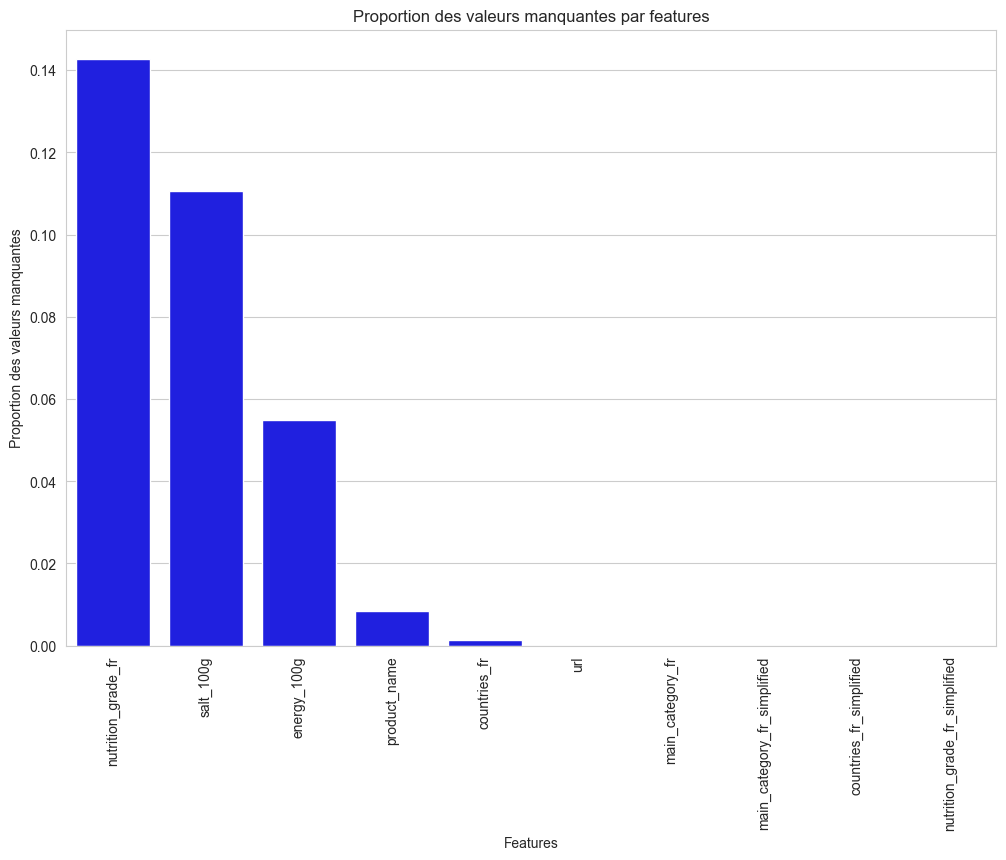

/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_47502/1312762621.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[f'{target}_simplified'] = data_filtered[target].apply(lambda x: x if x in to_keep_target else 'Autres')


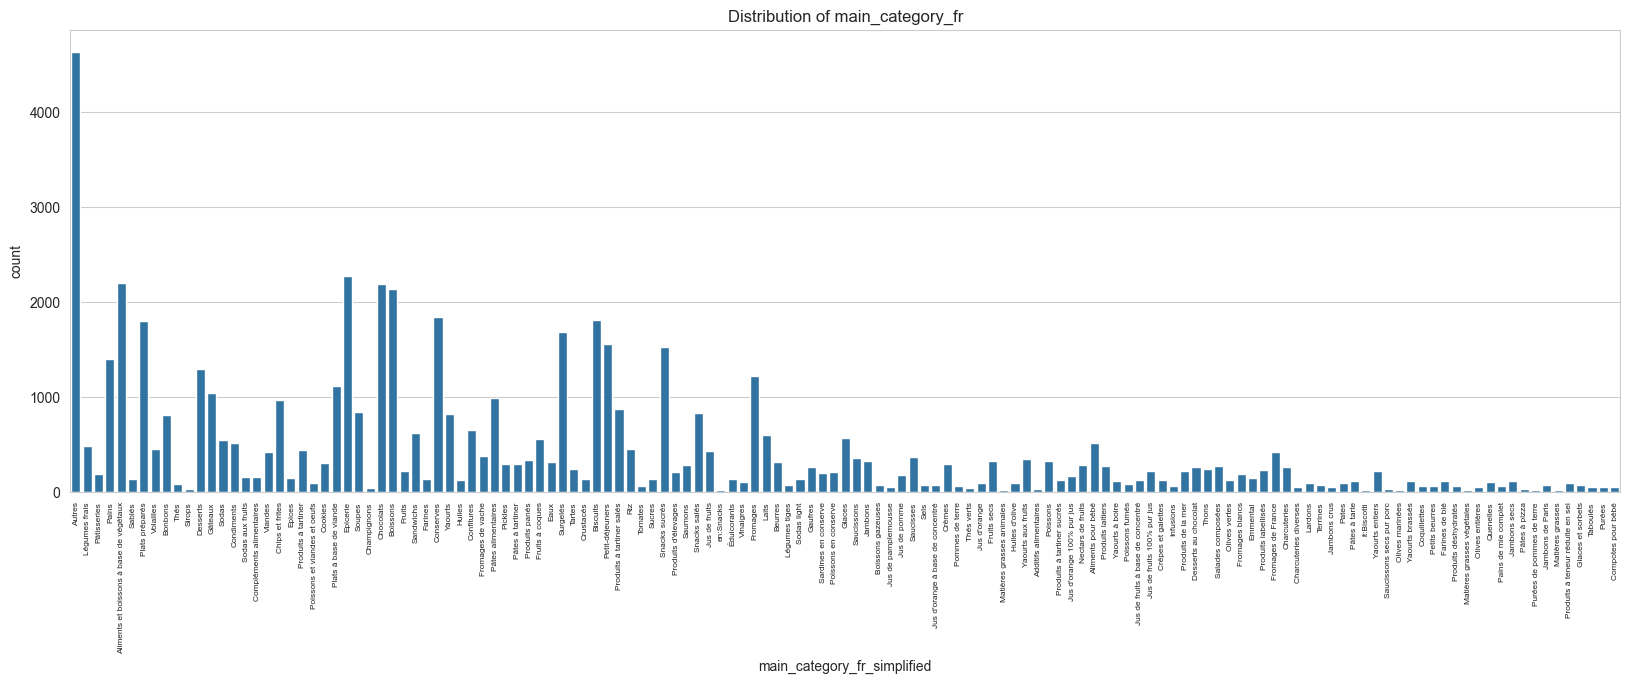

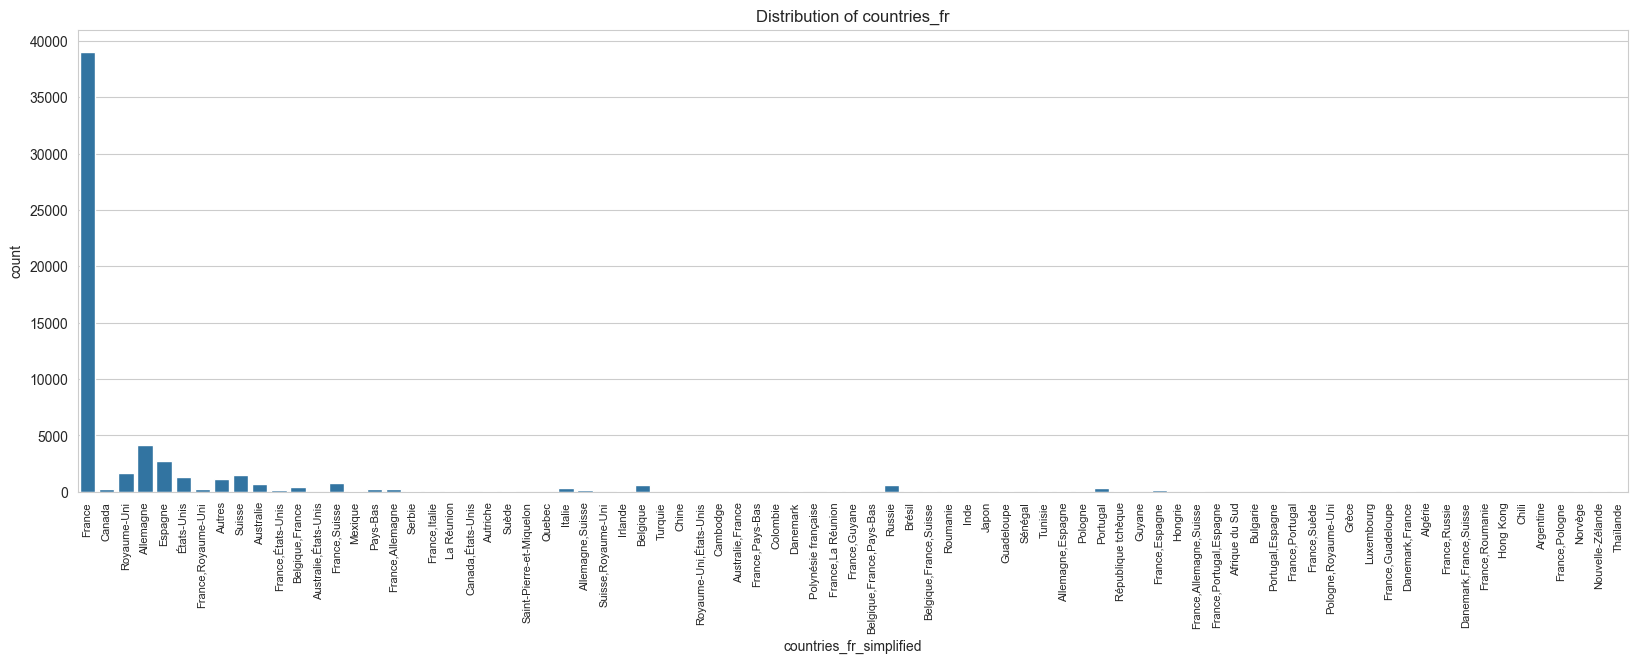

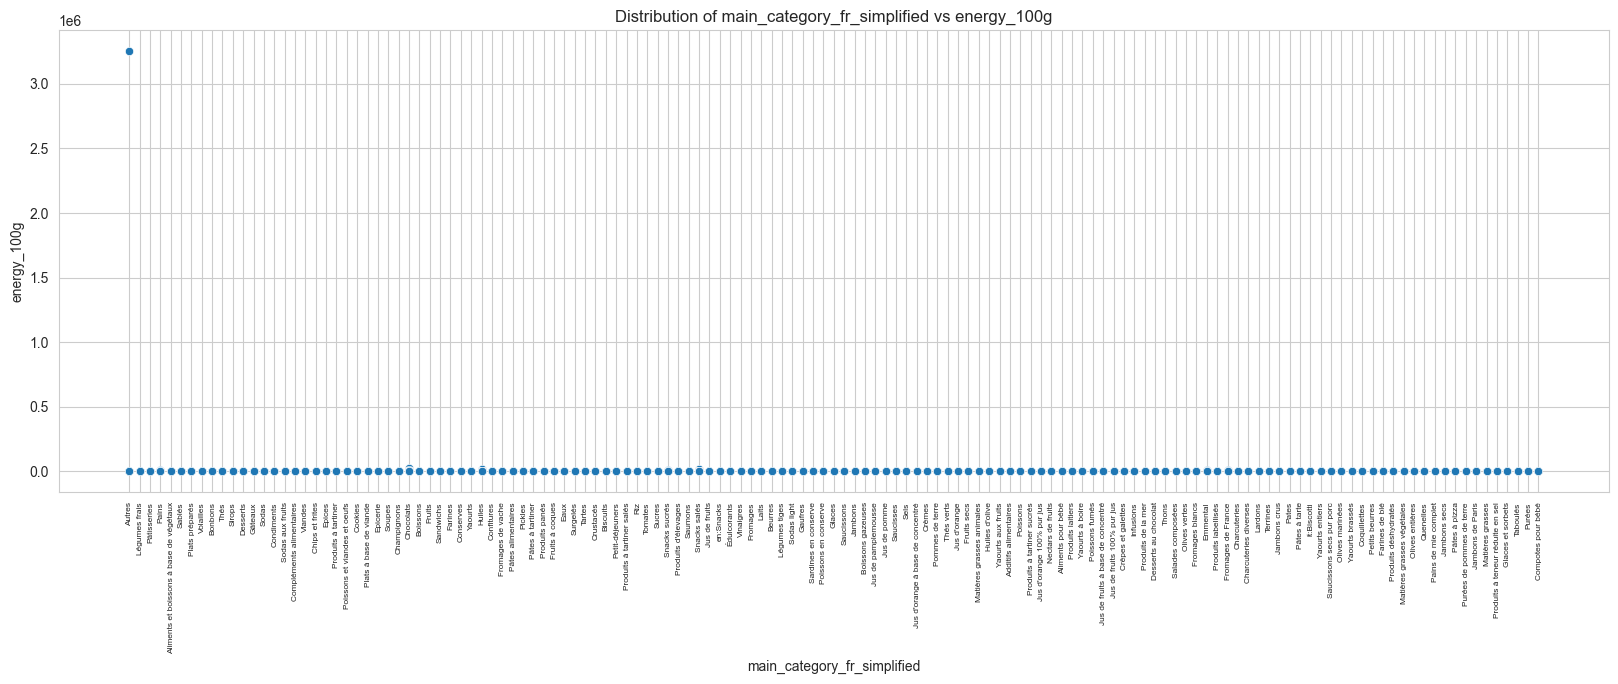

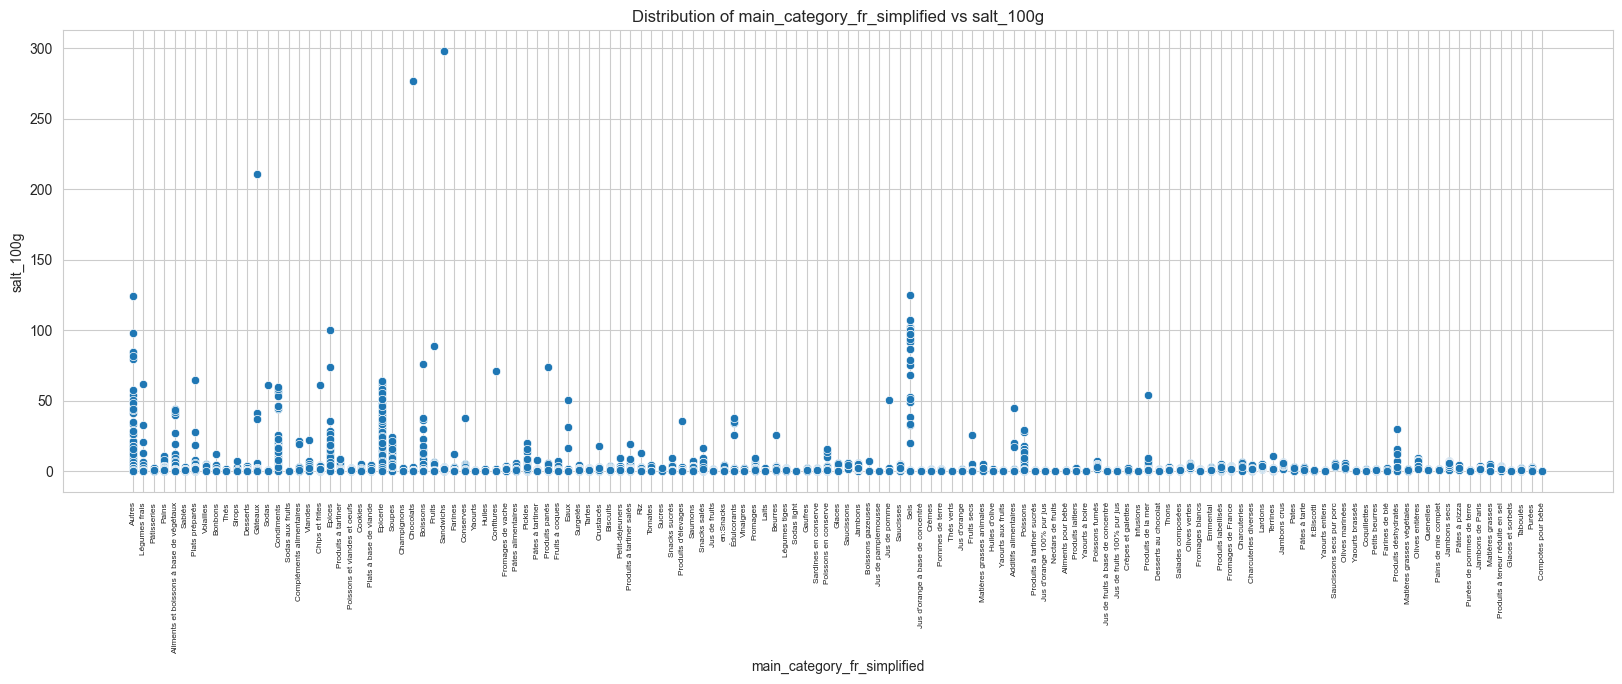

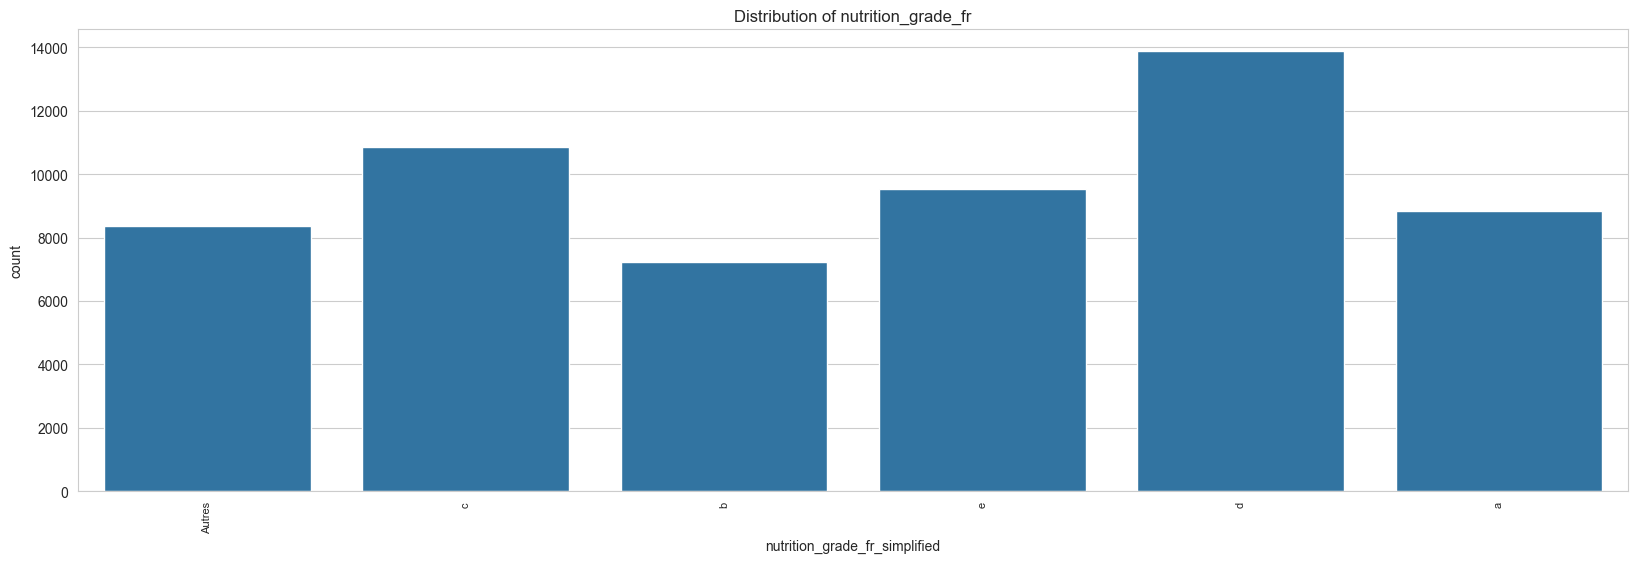

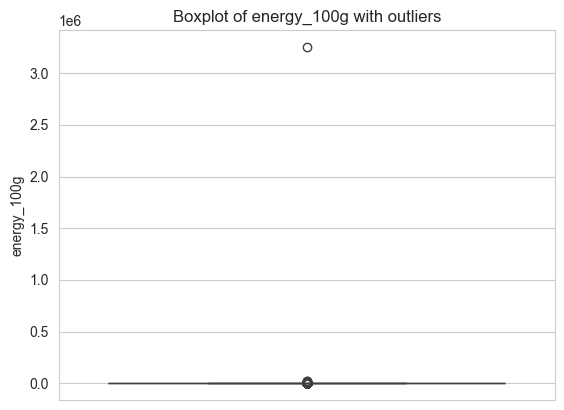

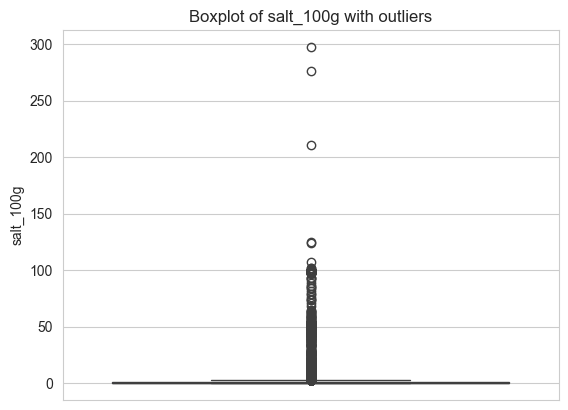

Outliers de energy_100g
lower_limit de energy_100g: 0
upper_limit de energy_100g: 3619.5


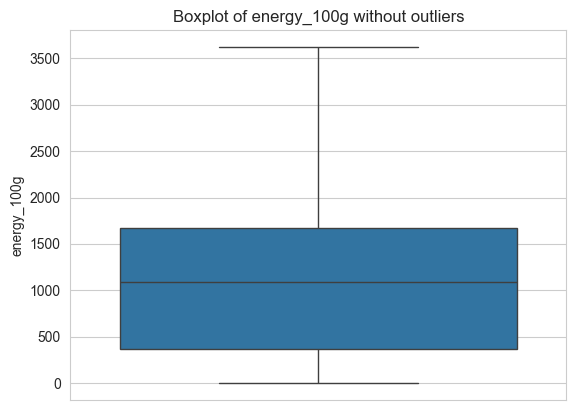

Outliers de salt_100g
lower_limit de salt_100g: 0
upper_limit de salt_100g: 3.3400999999999996


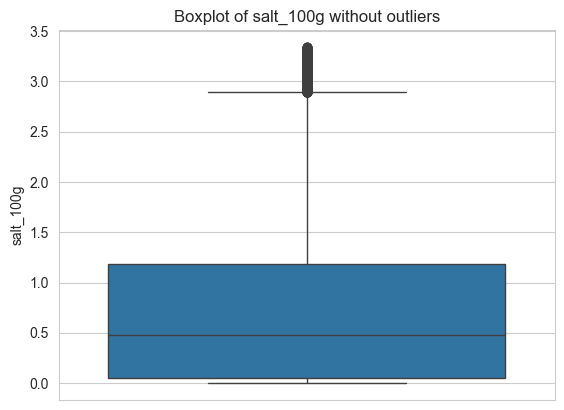

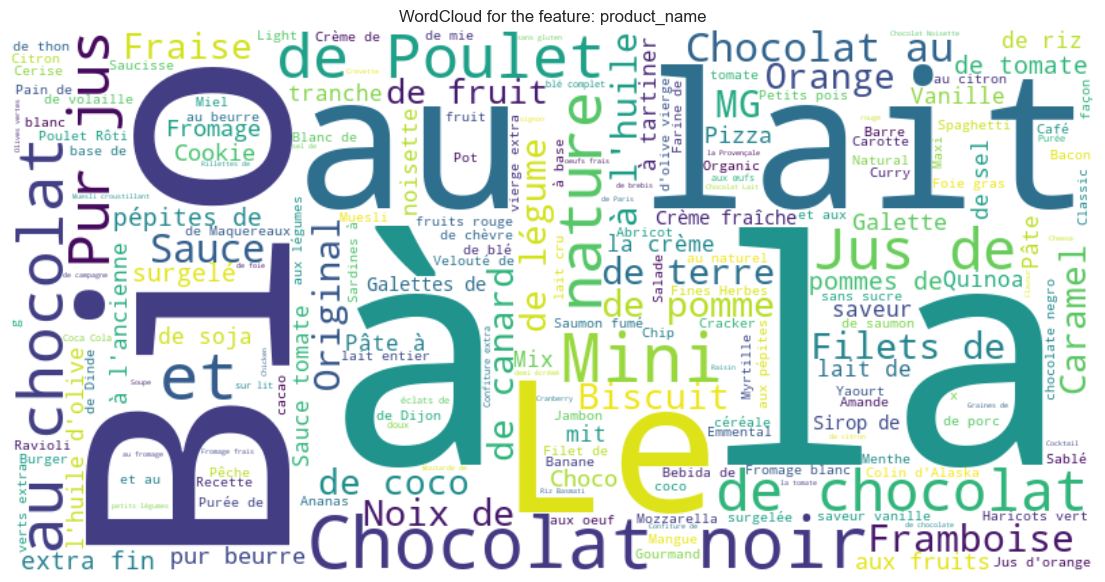

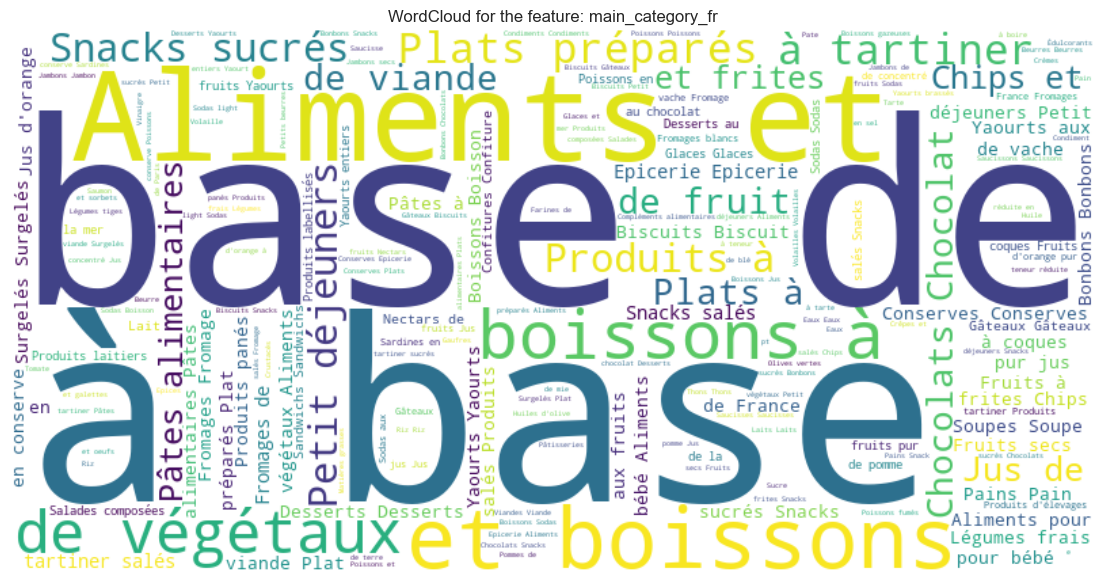

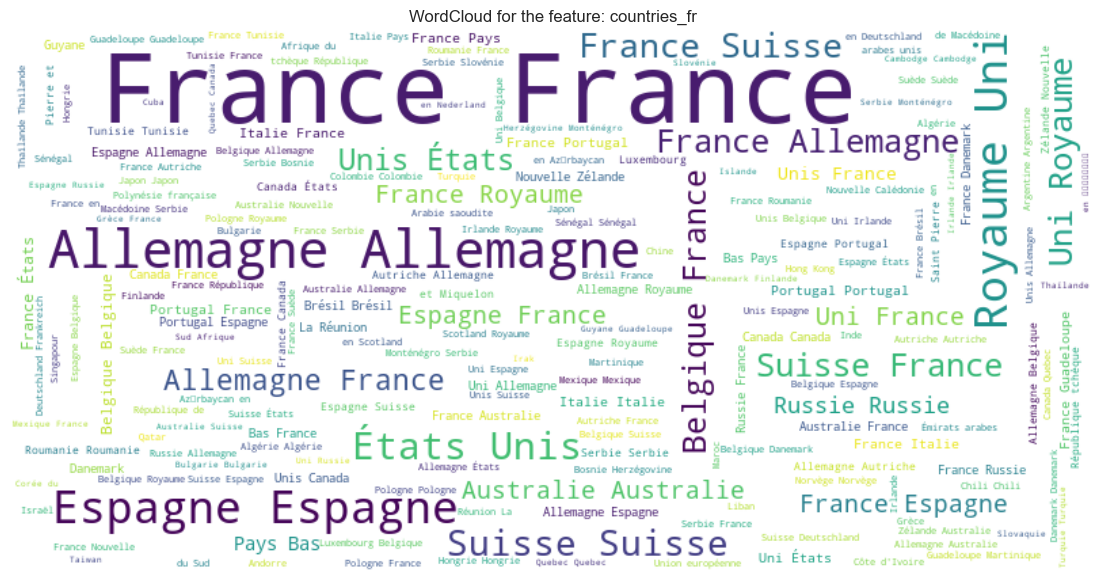

In [76]:
missing_value_prop(data_filtered)
graph_analysis(data_filtered)
# missing_prop(data_filtered)
boxplot_before_IQR(quantitative_features,data_filtered)
outliers_calc(quantitative_features,data_filtered)
worcloud_graph(data_filtered,qualitative_features)